In [18]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")

In [19]:
from langchain_core.messages import AIMessage, HumanMessage
from pprint import PrettyPrinter

messages = [
    AIMessage(content=f"Please tell me how can I help", name="LLMModel"),
    HumanMessage(content=f"I want to learn coding", name="Hitesh")
]

# messages.append(AIMessage(content=f"Which programming langauge you want to learn", name="LLMModel"))

In [20]:
for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help
================================ Human Message =================================
Name: Hitesh

I want to learn coding


In [21]:
## Chat Model
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o")

In [22]:
model.invoke(messages)

AIMessage(content="That's great! Learning to code can be a rewarding skill and can open up many opportunities. Here’s a step-by-step guide to help you get started:\n\n1. **Choose a Programming Language:**\n   - **Beginner-Friendly:** Python is highly recommended for beginners due to its simplicity and readability.\n   - **Web Development:** HTML/CSS (for structure and design) and JavaScript (for interactive elements).\n   - **Mobile Development:** Swift for iOS, Java/Kotlin for Android.\n   - **Data Science:** Python and R are popular choices.\n   - Focus on one language to start with, then diversify as needed.\n\n2. **Set Up Your Environment:**\n   - Download and install a code editor or Integrated Development Environment (IDE) like VSCode, PyCharm, or Jupyter Notebook for Python.\n   - Ensure you have the necessary software installed (e.g., Python from python.org if you choose it as your language).\n\n3. **Learn the Basics:**\n   - Understand basic programming concepts such as variab

### Tools 

In [23]:
## Creating the tools 
def add(a:int,b:int) -> int:
    """Add a and b together
    
    Args:
        a: int
        b: int
        
    Returns:
        int: The sum of a and b
    """
    return a + b

In [24]:
## Binding the tools to the model 
llm_with_tools = model.bind_tools([add])

In [25]:
response = llm_with_tools.invoke([
    HumanMessage(content=f"What is 2 + 2?", name="Hitesh")
])

In [26]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tADImLwRu2xuVAu80mLVGTvN', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 62, 'total_tokens': 79, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BcToeFxmP4KG3QcYwMXbiEJsq4dA0', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0ef47f97-c16b-4756-a374-b4f7ac61dfb0-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': 'call_tADImLwRu2xuVAu80mLVGTvN', 'type': 'tool_call'}], usage_metadata={'input_tokens': 62, 'output_tokens': 17, 'total_tokens': 79, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'o

### Using message as state

In [27]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


### Reducer with add_messages

In [29]:
initial_messages = [
    AIMessage(content=f"Please tell me how can I help", name="LLMModel"),
    HumanMessage(content=f"I want to learn coding", name="Hitesh")
]


In [30]:
ai_message = AIMessage(content=f"Which programming langauge you want to learn", name="LLMModel")

In [32]:
### Reducers add_messages is to append the messages
add_messages(initial_messages, ai_message)

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='1ba6ddba-f22e-4347-afe9-75c81e5f77fd'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Hitesh', id='80bf9ee7-a329-4c4e-8b99-9729dc47e1e7'),
 AIMessage(content='Which programming langauge you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='acb98101-db72-409c-b970-528f9f4d4364')]

In [33]:
def llm_tool(state: State) -> State:
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}


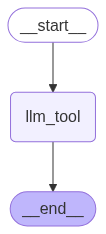

In [35]:
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image

## Creating the graph
graph = StateGraph(State)

## Adding the nodes
graph.add_node("llm_tool", llm_tool)

## Adding the edges
graph.add_edge(START, "llm_tool")
graph.add_edge("llm_tool", END)

## Running the graph
graph_builder = graph.compile()

# Displaying the graph
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [36]:
## Running the graph
messages = graph_builder.invoke({"messages": "What is 2 + 2?"})

for message in messages["messages"]:
    message.pretty_print()


================================ Human Message =================================

What is 2 + 2?
================================== Ai Message ==================================
Tool Calls:
  add (call_o9Ngy1f8wkVLDKRy3MTknnqi)
 Call ID: call_o9Ngy1f8wkVLDKRy3MTknnqi
  Args:
    a: 2
    b: 2


In [38]:
tools=[add]

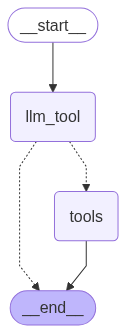

In [40]:
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image
from langgraph.prebuilt import ToolNode, tools_condition

## Creating the graph
graph = StateGraph(State)

## Adding the nodes
graph.add_node("llm_tool", llm_tool)
graph.add_node("tools", ToolNode(tools))

## Adding the edges
graph.add_edge(START, "llm_tool")
graph.add_conditional_edges("llm_tool", tools_condition)
graph.add_edge("tools", END)

## Running the graph
graph_builder = graph.compile()

# Displaying the graph
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [41]:
## Running the graph
messages = graph_builder.invoke({"messages": "What is 2 + 2?"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 + 2?
================================== Ai Message ==================================
Tool Calls:
  add (call_Yyzk0YL0HHSeS0GD8XxkxTG4)
 Call ID: call_Yyzk0YL0HHSeS0GD8XxkxTG4
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [42]:
## Running the graph
messages = graph_builder.invoke({"messages": "What is machine learning?"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is machine learning?
================================== Ai Message ==================================

Machine learning is a subset of artificial intelligence (AI) that involves the development of algorithms and statistical models that enable computers to perform tasks without explicit instructions. Instead of being programmed with a specific task, a machine learning model is trained using large amounts of data and algorithms that give it the ability to learn and improve over time. This process involves identifying patterns and making data-driven predictions or decisions.

Key aspects of machine learning include:

1. **Data Input**: Machine learning models require input data to learn from. The quality and quantity of this data can significantly affect the model's performance.

2. **Algorithms**: Different algorithms and techniques are used to find patterns within the data. These can be supervised (wi